# Scaling Laws

A common question in neural network training is, how should I select my hyperparameters? While a proper hyperparameter sweep will always provide the best answer, sweeps can become impractical especially at larger network sizes. In this case, the field has converged to two main options: 1), copy what a previous project used (which is always a good starting point), or 2) derive *scaling laws* which can predict what the best hyperparameters will be.

In this homework question, we will derive a simple scaling law for the optimal learning rate under varying batch sizes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

First, let's consider the case of a simple least-squares gradient descent problem. We will define our dataset using a randomly-sampled ground truth linear mapping, and our training samples will be augmented by some amount of noise. For this homework, we will focus on the question of **how should learning rate scale with batch size?**

In [ ]:
np.random.seed(0)
N = 10000  # number of data samples
D = 16  # input dimension
sigma = 5.0  # noise std

X_train = np.random.randn(N, D)  # gaussian inputs for training data
X_test = np.random.randn(1_000, D)  # gaussian inputs for test data
w_true = np.random.randn(D, D)  # ground truth weight
y_train = X_train @ w_true + sigma * np.random.randn(N, D)  # noisy outputs training data
y_test = X_test @ w_true + sigma * np.random.randn(1_000, D)  # noisy outputs test data


def analytical_solution(X: np.ndarray, y: np.ndarray, n: int) -> np.ndarray:
    """Calculates the analytical solution for a least-squares problem.

    Args:
        X: Input data matrix.
        y: Target data matrix.
        n: Number of samples to consider.

    Returns:
        The analytical weight matrix.
    """
    pseudo_inv_X = np.linalg.pinv(X[:n, :], rcond=0)  # pseudo-inverse of X
    w_analytical = pseudo_inv_X @ y[:n, :]  # analytical solution
    return w_analytical


def compute_mse(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """Computes the Mean Squared Error (MSE).

    Args:
        X: Input data matrix.
        y: True target values.
        w: Predicted weights.

    Returns:
        The Mean Squared Error.
    """
    y_pred = X @ w  # predicted outputs
    mse = np.mean((y - y_pred)**2)  # mean squared error
    return mse


def compute_losses(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    N: int
) -> tuple[list[int], list[float], list[float]]:
    """Computes training and testing losses for analytical solutions across different sample sizes.

    Args:
        X_train: Training input data.
        y_train: Training target data.
        X_test: Test input data.
        y_test: Test target data.
        N: Total number of samples.

    Returns:
        A tuple containing lists of sample sizes, training losses, and test losses.
    """
    train_losses = []
    test_losses = []
    ns = list(range(1, N + 1))
    for n in ns:
        w_analytical = analytical_solution(X_train, y_train, n)
        train_mse = compute_mse(X_train, y_train, w_analytical)
        test_mse = compute_mse(X_test, y_test, w_analytical)
        train_losses.append(train_mse)
        test_losses.append(test_mse)
    return ns, train_losses, test_losses

In [ ]:
def run_sgd(iters: int, batch_size: int, lr: float) -> tuple[np.ndarray, list[float], list[float]]:
    """Runs Stochastic Gradient Descent for a least-squares problem.

    Args:
        iters: Number of training iterations.
        batch_size: Size of each mini-batch.
        lr: Learning rate.

    Returns:
        A tuple containing the final weights, training MSEs, and test MSEs.
    """
    np.random.seed(0)
    w_init = np.random.randn(D, D)

    test_sgd_mse = []
    train_sgd_mse = []

    w = w_init
    for i in range(iters):
        idx = np.random.randint(0, N, batch_size)
        x = X_train[idx]
        y = y_train[idx]
        # Gradient for least squares: d/dw (1/N * ||Xw - y||^2) = (2/N) * X.T @ (Xw - y)
        grad = (2 / batch_size) * (x.T @ x @ w - x.T @ y)  # shape (D, D)

        w = w - lr * grad
        train_mse = compute_mse(x, y, w)
        test_mse = compute_mse(X_test, y_test, w)
        test_sgd_mse.append(test_mse)
        train_sgd_mse.append(train_mse)

    return w, train_sgd_mse, test_sgd_mse

In [ ]:
w, train_sgd_mse, test_sgd_mse = run_sgd(iters=100, batch_size=32, lr=0.01)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sgd_mse, label='Train Loss')
ax.plot(test_sgd_mse, label='Test Loss')
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel('Squared Error')
ax.legend()

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


We can plot the above curves on log-linear scale while subtracting off the irreducible error of $\sigma^2$ to see the linear decay of the squared error. This allows for a better view of the convergence rate.

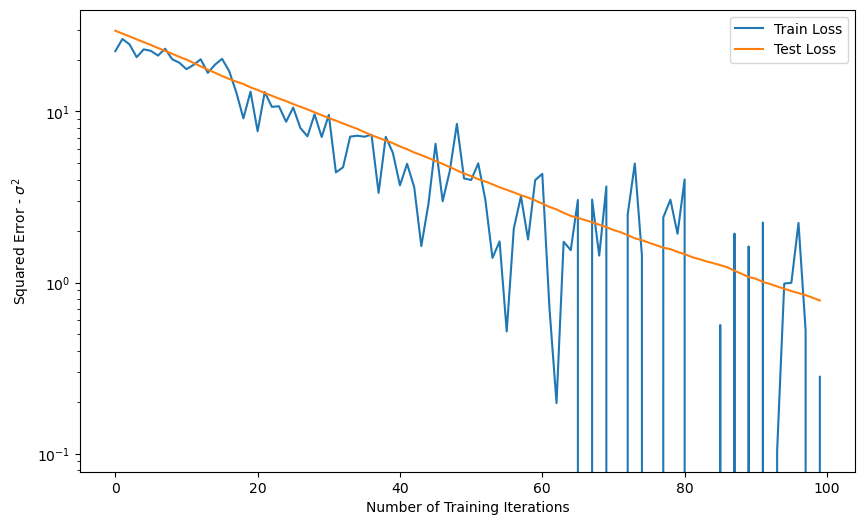

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
train_sgd_mse_res = [mse - sigma**2 for mse in train_sgd_mse]
test_sgd_mse_res = [mse - sigma**2 for mse in test_sgd_mse]
ax.plot(train_sgd_mse_res, label='Train Loss')
ax.plot(test_sgd_mse_res, label='Test Loss')
ax.set_yscale('log')
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel(r'Squared Error - $\sigma^2$')
ax.legend()

## Q1: Scaling law for least-squares SGD.

Perform a sweep over learning rates. Consider the batch sizes between [2, 4, 16, 64, 256, 1024, 2048], and sweep over learning rates logarithmically with a resolution of $1.25$. For example, you should consider the learning rate of $0.001, 0.001 * 1.25, 0.001 * 1.25^2$, etc. **Make sure your learning rate sweep covers the optimal LR for each batch size (e.g. your optimal LR should not be at the boundary of your learning rate intervals.) You should be able to sweep around ~32 learning rates per batch size.

- Plot your learning rates on the same graph, with each batchsize as a different curve. You curve should resemble the example provided.
- Plot the relationship between batch size (x-axis) and the optimal learning rate (y-axis). What function does this resemble?

Hint: Many runs will result in very high losses if the iteration diverges. It will help to clip the losses to some ceiling value before plotting.

Hint 2: You may find that some batch sizes have a wide basin of optimal learning rates that perform roughly equivalently. In this case, it may help to plot the *average* learning rate that is within X% of the optimal. This can make the relationship more clear.

![fig-example](fig-example.png)

In [ ]:
import numpy as np
from typing import List, Dict

lrs = np.logspace(-3, 0, 32)
batch_sizes = [2, 4, 16, 64, 256, 1024, 2048]

final_mse_dict = {}

for batch_size_val in batch_sizes:
    final_mse_dict[batch_size_val] = []
    for lr in lrs:
        # Assuming run_sgd returns np.ndarray, List[float], List[float]
        _, _, test_sgd_mse = run_sgd(iters=100, batch_size=batch_size_val, lr=lr)
        test_mse_mean = float(np.mean(test_sgd_mse[-10:]))  # Average over last 10 iterations
        final_mse_dict[batch_size_val].append(test_mse_mean)

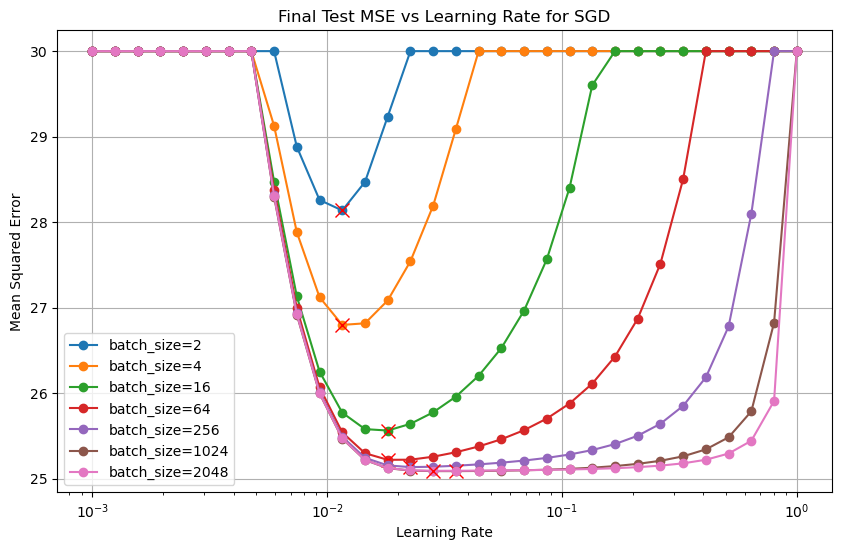

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for batch_size in batch_sizes:
    final_test_mses = final_mse_dict[batch_size]
    final_test_mses = np.array(final_test_mses)
    final_test_mses = np.minimum(final_test_mses, 30)
    ax.plot(lrs, final_test_mses, label=f'batch_size={batch_size}', marker='o')
    best_lr = lrs[np.argmin(final_test_mses)]
    ax.plot(best_lr, np.min(final_test_mses), marker='x', markersize=10, color='red')

ax.set_xlabel('Learning Rate')
ax.set_ylabel(f'Mean Squared Error')
ax.set_title('Final Test MSE vs Learning Rate for SGD')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

[0.011601553017399714, 0.011601553017399714, 0.018116091942004142, 0.018116091942004142, 0.022638034095214477, 0.03534981105030106, 0.028288694346259694]


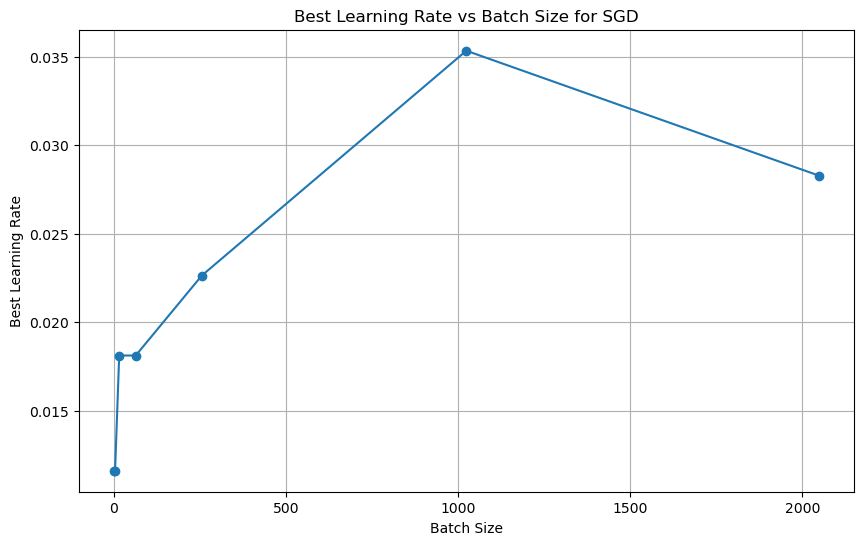

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

plt.figure(figsize=(10, 6))
optimal_lrs_sgd = [lrs[np.argmin(final_mse_dict[batch_size_val])] for batch_size_val in batch_sizes]
print(f"Optimal Learning Rates for SGD: {optimal_lrs_sgd}")
plt.plot(batch_sizes, optimal_lrs_sgd, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Optimal Learning Rate')
plt.title('Optimal Learning Rate vs Batch Size for SGD (Least Squares)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

## Q2: MLP with SGD

We will now repeat a similar study, using a two-layer MLP rather than a linear regression. Again, conduct a sweep on the relationship between batch size and optimal learning rate. How does this relationship compare to the optimum for least-squares SGD?

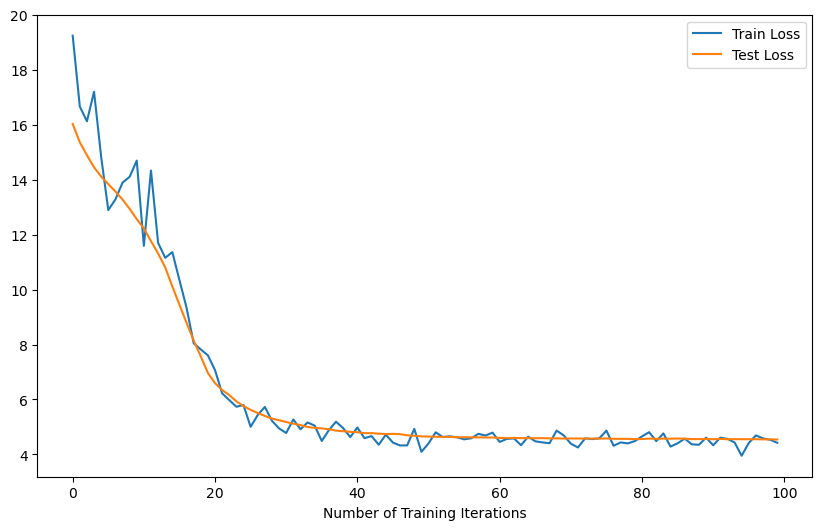

In [ ]:
N = 10000  # number of data samples
D = 4  # input dimension
sigma = 2.0  # noise std

np.random.seed(0)
X_train = np.random.randn(N, D)  # gaussian inputs for training data
X_test = np.random.randn(1_000, D)  # gaussian inputs for test data
W1_true = np.random.randn(D, D)  # ground truth weight
W2_true = np.random.randn(D, D)  # ground truth weight
y_train = np.maximum(0, X_train @ W1_true) @ W2_true + sigma * np.random.randn(N, D)  # noisy outputs training data
y_test = np.maximum(0, X_test @ W1_true) @ W2_true + sigma * np.random.randn(1_000, D)  # noisy outputs test data

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


def model_inst(input_dim: int) -> tuple[torch.nn.Module, torch.nn.modules.loss._Loss]:
    """Initializes a two-layer MLP model and MSE loss function.

    Args:
        input_dim: The input and output dimension of the MLP.

    Returns:
        A tuple containing the MLP model and the MSE loss function.
    """
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, input_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(input_dim, input_dim)
    )

    loss_fn = torch.nn.MSELoss()
    return model, loss_fn


def train_mlp_sgd(iters: int, batch_size: int, lr: float, opt: str = 'SGD') -> tuple[list[float], list[float]]:
    """Trains an MLP model using SGD or Adam optimizer.

    Args:
        iters: Number of training iterations.
        batch_size: Size of each mini-batch.
        lr: Learning rate.
        opt: Optimizer to use ('SGD' or 'Adam').

    Returns:
        A tuple containing lists of training MSEs and test MSEs.
    """
    torch.manual_seed(0)
    np.random.seed(0)
    model, loss_fn = model_inst(D)
    scheduler = None

    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif opt == 'Adam':
        # TODO
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.5), weight_decay=0.01)
        scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=10)
        scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iters - 10)
        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[scheduler1, scheduler2],
            milestones=[10],
        )
        #
    else:
        raise ValueError("Optimizer not recognized")

    test_sgd_mse = []
    train_sgd_mse = []

    for i in range(iters):
        idx = np.random.randint(0, N, batch_size)
        x = torch.tensor(X_train[idx], dtype=torch.float32)
        y = torch.tensor(y_train[idx], dtype=torch.float32)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        test_sgd_mse.append(loss_fn(model(X_test_tensor), y_test_tensor).item())
        train_sgd_mse.append(loss_fn(model(x), y).item())

    return train_sgd_mse, test_sgd_mse


mlp_train_mse, mlp_test_mse = train_mlp_sgd(iters=100, batch_size=256, lr=0.1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mlp_train_mse, label='Train Loss')
ax.plot(mlp_test_mse, label='Test Loss')
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel('Squared Error')
ax.legend()

Again, let's plot on log-linear scale minus the offset. Notice that the MLP converges to $\approx \sigma^2 + 0.57$ as opposed to $\sigma^2$.

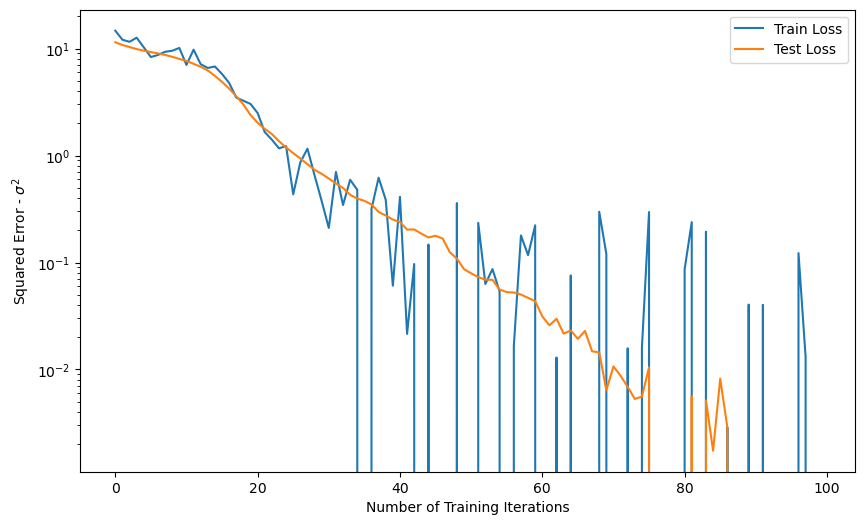

In [ ]:
eps = 0.57
mlp_train_mse_res = [mse - (sigma**2 + eps) for mse in mlp_train_mse]
mlp_test_mse_res = [mse - (sigma**2 + eps) for mse in mlp_test_mse]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mlp_train_mse_res, label='Train Loss')
ax.plot(mlp_test_mse_res, label='Test Loss')
ax.set_xlabel('Number of Training Iterations')
ax.set_ylabel(r'Squared Error - $\sigma^2$')
ax.set_yscale('log')
ax.legend()

In [ ]:
import numpy as np
from typing import List, Dict

lrs = np.logspace(-2, 0, 32)
batch_sizes = [2, 4, 16, 64, 256, 1024, 2048]
final_mse_dict = {}

for batch_size_val in batch_sizes:
    final_mse_dict[batch_size_val] = []
    for lr in lrs:
        # Assuming train_mlp_sgd returns List[float], List[float]
        _, test_mlp_mses = train_mlp_sgd(iters=200, batch_size=batch_size_val, lr=lr)
        # Average over the last 30 iterations for stability
        test_mse_mean = float(np.mean(test_mlp_mses[-30:]))
        if np.isnan(test_mse_mean):
            test_mse_mean = 30.0  # Clip NaN losses to a ceiling value
        final_mse_dict[batch_size_val].append(test_mse_mean)

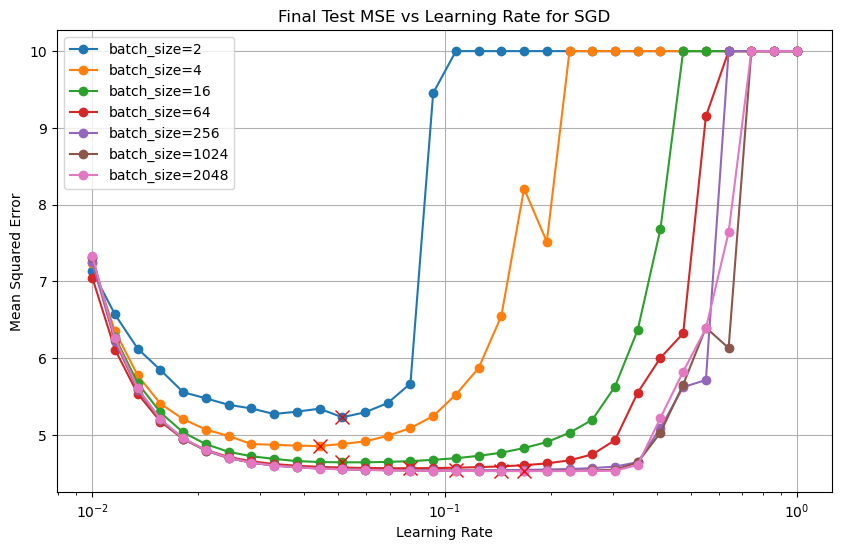

[0.05124805876960934, 0.044173447031400685, 0.05124805876960934, 0.08002502278161053, 0.10771050560367691, 0.14497406703726315, 0.16819243248808696]


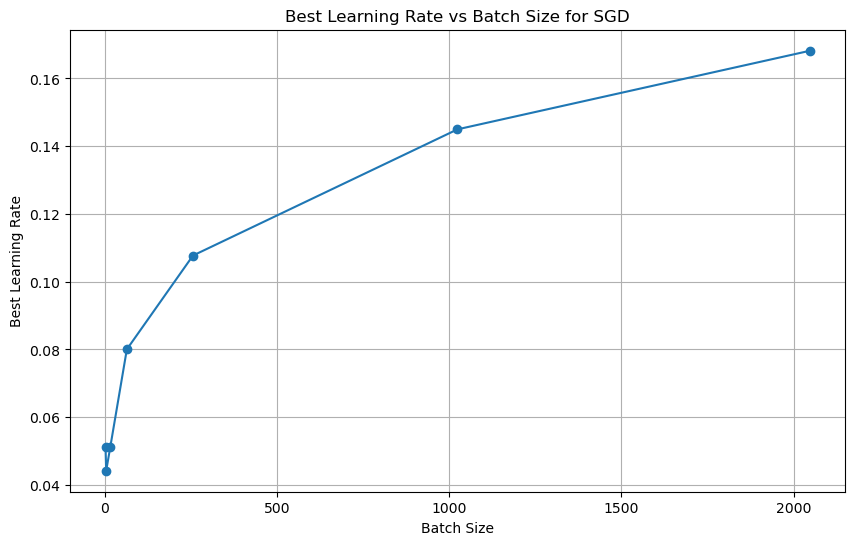

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

fig, ax = plt.subplots(figsize=(10, 6))
for batch_size_val in batch_sizes:
    final_test_mses_raw = np.array(final_mse_dict[batch_size_val])
    final_test_mses_clipped = np.where(np.isnan(final_test_mses_raw), 30.0, final_test_mses_raw)
    final_test_mses_clipped = np.minimum(final_test_mses_clipped, 10.0)  # Clipping to 10.0

    ax.plot(lrs, final_test_mses_clipped, label=f'batch_size={batch_size_val}', marker='o')

    # Find the best learning rate for this batch size
    best_lr_idx = np.argmin(final_test_mses_clipped)
    optimal_lr = lrs[best_lr_idx]
    min_mse = float(np.min(final_test_mses_clipped))
    ax.plot(optimal_lr, min_mse, marker='x', markersize=10, color='red')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Final Test MSE vs Learning Rate for MLP SGD')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

# Plot optimal learning rate vs batch size
plt.figure(figsize=(10, 6))
optimal_lrs_mlp_sgd = []
for batch_size_val in batch_sizes:
    final_test_mses_raw = np.array(final_mse_dict[batch_size_val])
    final_test_mses_clipped = np.where(np.isnan(final_test_mses_raw), 30.0, final_test_mses_raw)
    final_test_mses_clipped = np.minimum(final_test_mses_clipped, 10.0)

    best_lr_idx_mlp_sgd = np.argmin(final_test_mses_clipped)
    optimal_lrs_mlp_sgd.append(lrs[best_lr_idx_mlp_sgd])

print(f"Optimal Learning Rates for MLP SGD: {optimal_lrs_mlp_sgd}")
plt.plot(batch_sizes, optimal_lrs_mlp_sgd, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Optimal Learning Rate')
plt.title('Optimal Learning Rate vs Batch Size for MLP SGD')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

#### Q3: MLP with Adam.

Finally, we will repeat the scaling law curve, but using the Adam optimizer. This time, implement a learning rate schedule, such that the learning rate has a linear warmup for 10 steps, then uses cosine decay for the rest of training. Use a beta1=0.5, beta2=0.5, and a weight decay of 0.001. As before, plot the comparison curves, then plot a curve of the batch size vs. optimal learning rate. Does the scaling for learning rate change with Adam vs. SGD?

In [ ]:
import numpy as np
from typing import List, Dict

lrs = np.logspace(-2, 1, 32)  # Learning rates from 0.01 to 10
batch_sizes = [2, 4, 16, 64, 256, 1024, 2048]

print(f"Batch sizes for Adam sweep: {batch_sizes}")

final_mse_dict = {}

for batch_size_val in batch_sizes:
    final_mse_dict[batch_size_val] = []
    for lr in lrs:
        # Assuming train_mlp_sgd returns List[float], List[float]
        _, test_mlp_mses = train_mlp_sgd(iters=200, batch_size=batch_size_val, lr=lr, opt='Adam')
        # Average over the last 30 iterations for stability
        test_mse_mean = float(np.mean(test_mlp_mses[-30:]))
        if np.isnan(test_mse_mean):
            test_mse_mean = 30.0  # Clip NaN losses to a ceiling value
        final_mse_dict[batch_size_val].append(test_mse_mean)

    print(f"Finished sweep for batch size: {batch_size_val}")

batch_sizes: [2, 4, 16, 64, 256, 1024, 2048]


/Users/sultandaniels/anaconda3/envs/cs289hw7/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


finished batch size 2
finished batch size 4
finished batch size 16
finished batch size 64
finished batch size 256
finished batch size 1024
finished batch size 2048


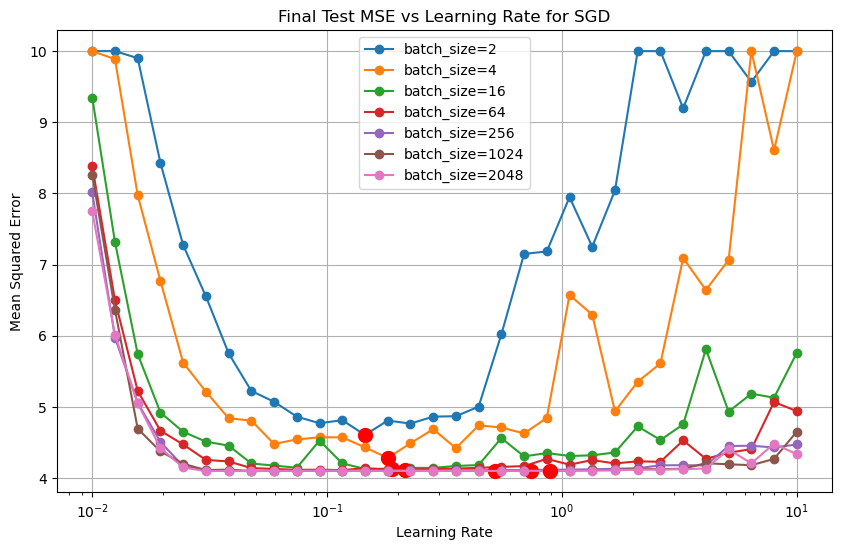

[0.14497406703726315, 0.18116091942004142, 0.18895035479092148, 0.2144015678120544, 0.5199916995242735, 0.7412784268477398, 0.887358802660938]


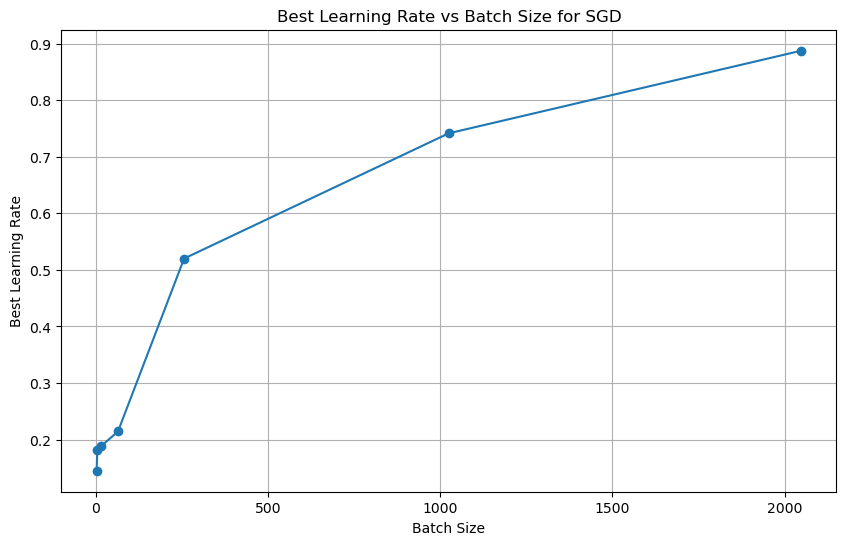

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

fig, ax = plt.subplots(figsize=(10, 6))
for batch_size_val in batch_sizes:
    final_test_mses_raw = np.array(final_mse_dict[batch_size_val])
    final_test_mses_clipped = np.where(np.isnan(final_test_mses_raw), 30.0, final_test_mses_raw)
    final_test_mses_clipped = np.minimum(final_test_mses_clipped, 10.0)  # Clipping to 10.0

    ax.plot(lrs, final_test_mses_clipped, label=f'batch_size={batch_size_val}', marker='o')

    # Calculate optimal LR based on a basin of optimal performance (within 0.05 of min loss)
    best_loss = float(np.min(final_mse_dict[batch_size_val]))
    lrs_in_optimal_basin = [
        lr_val for i, lr_val in enumerate(lrs)
        if final_mse_dict[batch_size_val][i] - best_loss < 0.05
    ]

    optimal_lr_for_plot: float
    if lrs_in_optimal_basin:
        optimal_lr_for_plot = float(np.mean(lrs_in_optimal_basin))
    else:
        # Fallback to single best LR if no basin found
        optimal_lr_for_plot = lrs[np.argmin(final_test_mses_clipped)]

    min_mse_clipped = float(np.min(final_test_mses_clipped))
    ax.plot(optimal_lr_for_plot, min_mse_clipped, marker='x', markersize=10, color='red')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Final Test MSE vs Learning Rate for MLP Adam')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

# Plot optimal learning rate vs batch size
plt.figure(figsize=(10, 6))
optimal_lrs_adam = []
for batch_size_val in batch_sizes:
    current_mses = final_mse_dict[batch_size_val]
    best_loss_current = float(np.min(current_mses))
    lrs_in_optimal_basin_current = [
        lr_val for i, lr_val in enumerate(lrs)
        if current_mses[i] - best_loss_current < 0.05
    ]
    if lrs_in_optimal_basin_current:
        optimal_lrs_adam.append(float(np.mean(lrs_in_optimal_basin_current)))
    else:
        # Fallback to single best LR if no basin found
        optimal_lrs_adam.append(lrs[np.argmin(np.array(current_mses))])

print(f"Optimal Learning Rates for MLP Adam: {optimal_lrs_adam}")
plt.plot(batch_sizes, optimal_lrs_adam, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Optimal Learning Rate')
plt.title('Optimal Learning Rate vs Batch Size for MLP Adam')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()